In [1]:
# Cross-batch cluster matching scratch work.

import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from scipy.stats import skew, kurtosis, norm, mode
from sklearn.cluster import DBSCAN, HDBSCAN
from sklearn.preprocessing import quantile_transform
import psutil
import shutil
import os
import umap
from sklearn.manifold import TSNE # https://distill.pub/2016/misread-tsne/
%matplotlib inline

/home/benjb/.conda/envs/sklearn-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
cci = np.load('/datax/scratch/benjb/C23_L_M31_injections/HDBSCAN/non_anom_centroid_idxs.npy', allow_pickle=True)
ccc = np.load('/datax/scratch/benjb/C23_L_M31_injections/HDBSCAN/non_anom_centroids.npy', allow_pickle=True)
print(ccc.shape)

(1785050, 13)


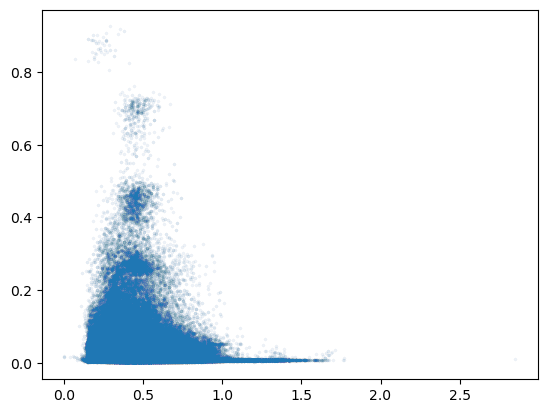

In [4]:
plt.scatter(ccc[:,9], ccc[:,11], s=3, alpha=0.01)
plt.show()

[0.5535264  0.7050128  0.83430082 0.90348047 0.9479321  0.97248973
 0.98304383 0.9898422  0.99297783 0.99579826 0.99808201 0.99940354
 1.        ]
[0.31381463 0.08588326 0.07329817 0.03922051 0.02520128 0.01392263
 0.00598351 0.00385425 0.0017777  0.00159901 0.00129474 0.00074923
 0.00033815]


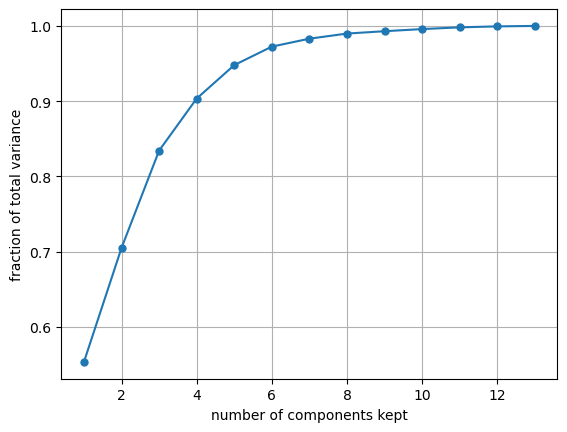

In [3]:
from sklearn.decomposition import PCA

X = np.copy(ccc)
pca = PCA()
pca.fit(X)
variances = pca.explained_variance_
cumulative_variance = [np.sum(variances[:i+1]) for i in range(len(variances))]
print(np.array(cumulative_variance)/np.sum(variances))

print(variances)

plt.plot(np.arange(len(variances))+1, np.array(cumulative_variance)/np.sum(variances), '.-', markersize=10)
plt.grid()
plt.ylabel('fraction of total variance')
plt.xlabel('number of components kept')
plt.show()

In [9]:
X_reduced = PCA(n_components=6, svd_solver='full').fit_transform(X)
X_reduced_4 = PCA(n_components=3, svd_solver='full').fit_transform(X)

In [162]:
X_reduced.shape

(1782224, 6)

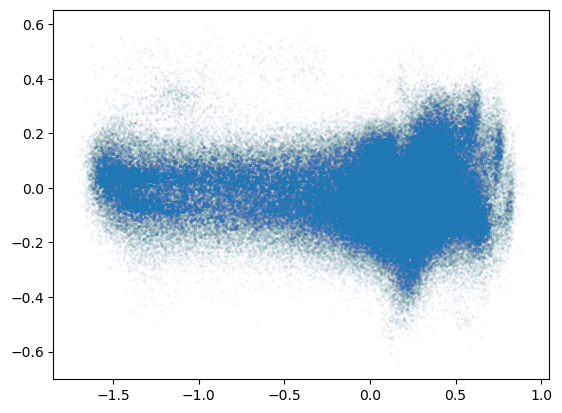

In [10]:
plt.scatter(X_reduced[:,0], X_reduced[:,5], s=3, linewidths=0, alpha=0.01)
plt.show()

In [147]:
X_reduced[:,:4].shape

(1782224, 4)

In [63]:
from sklearn.cluster import KMeans

kmeans = KMeans(init="random", n_clusters=15, n_init=10)

kmeans.fit(X_reduced)

KMeans(init='random', n_clusters=15, n_init=10)

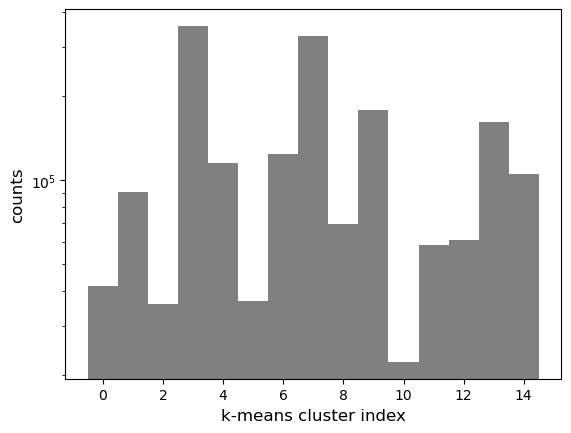

In [64]:
plt.hist(kmeans.labels_, bins=15, color='grey', range=(-0.5, 14.5))
plt.xlabel('k-means cluster index', size=12)
plt.ylabel('counts', size=12)
plt.yscale('log')
plt.show()

In [66]:
np.save('/datax/scratch/benjb/C23_L_kmeans_labels_k15.npy', kmeans.labels_)

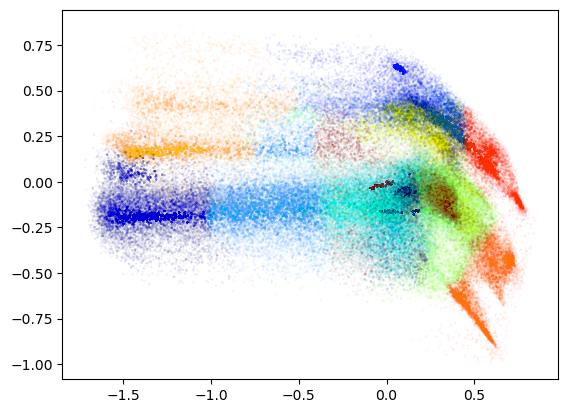

In [24]:
# k-means evidently blocky; not very good clustering

plt.scatter(X_reduced[:,0], X_reduced[:,1], s=3, c=kmeans.labels_, cmap='jet', linewidths=0, alpha=0.01)
plt.show()

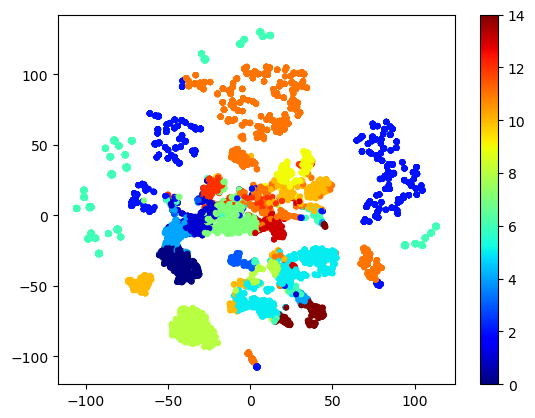

In [48]:
# k-means results also not borne out well on t-SNE embedding

iii = np.random.randint(0, 1782224, 10000)

xembed_2 = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=40, early_exaggeration=4).fit_transform(ccc[iii])

plt.scatter(xembed_2[:,0], xembed_2[:,1], c=kmeans.labels_[iii], cmap='jet', s=20, linewidths=0, alpha=1)
plt.colorbar()
plt.show()

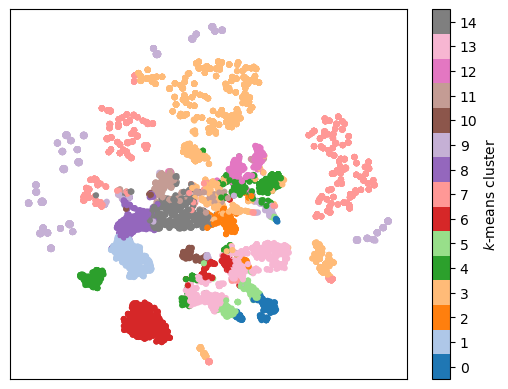

In [67]:
colors = plt.cm.tab20(np.linspace(0, 1, 20)[:15])
import matplotlib

def categorical_cmap(nc, nsc, cmap="tab10", continuous=False):
    if nc > plt.get_cmap(cmap).N:
        raise ValueError("Too many categories for colormap.")
    if continuous:
        ccolors = plt.get_cmap(cmap)(np.linspace(0,1,nc))
    else:
        ccolors = plt.get_cmap(cmap)(np.arange(nc, dtype=int))
    cols = np.zeros((nc*nsc, 3))
    for i, c in enumerate(ccolors):
        chsv = matplotlib.colors.rgb_to_hsv(c[:3])
        arhsv = np.tile(chsv,nsc).reshape(nsc,3)
        arhsv[:,1] = np.linspace(chsv[1],0.25,nsc)
        arhsv[:,2] = np.linspace(chsv[2],1,nsc)
        rgb = matplotlib.colors.hsv_to_rgb(arhsv)
        cols[i*nsc:(i+1)*nsc,:] = rgb       
    cmap = matplotlib.colors.ListedColormap(cols)
    return cmap

fig, ax = plt.subplots()
s = ax.scatter(xembed_2[:,0], xembed_2[:,1], 
            c=kmeans.labels_[iii], 
            cmap=categorical_cmap(15, 1, cmap='tab20'),
            vmin=-0.5, vmax=14.5,
            s=20, linewidths=0, alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(mappable=s, label=r'$k$-means cluster', ax=ax, ticks=np.arange(15))
plt.savefig('/datax/scratch/benjb/C23_L_kmeans_TSNE_visualization_10k_hits.pdf', bbox_inches='tight')
plt.show()

In [128]:
print(iii.shape)

(10000,)


In [52]:
np.savez('/datax/scratch/benjb/C23_L_idxs_centroids_embedding_used_for_10k_tSNE_visualization_110624.npz', cci[iii], ccc[iii], xembed)

In [53]:
np.save('/datax/scratch/benjb/C23_L_HDBSCAN_tSNE_10k_labels_110624.npy', hdb.labels_)

In [5]:
unique_ccc, unique_inv, counts = np.unique(ccc, axis=0, return_inverse=True, return_counts=True)

In [20]:
low_count_cci = []
low_count_ccc = []
for i, count in enumerate(counts):
    if count > 500:
        continue
    centroid = unique_ccc[i]
    idxs = cci[np.where(unique_inv == i)[0]]
    cents = ccc[np.where(unique_inv == i)[0]]
    low_count_cci.append(idxs)
    low_count_ccc.append(cents)
    #needed_params = hit_params[idxs]
    #needed_dats = hit_dats[idxs]
    #random_sample_idxs = np.random.choice(len(needed_params), 20, replace=False)
    #random_sample_params = needed_params[random_sample_idxs]
    #random_sample_dats = needed_dats[random_sample_idxs]
low_count_cci = np.concatenate(low_count_cci)
low_count_ccc = np.concatenate(low_count_ccc)
print(low_count_cci.shape)
print(low_count_ccc.shape)


(1704924,)
(1704924, 13)


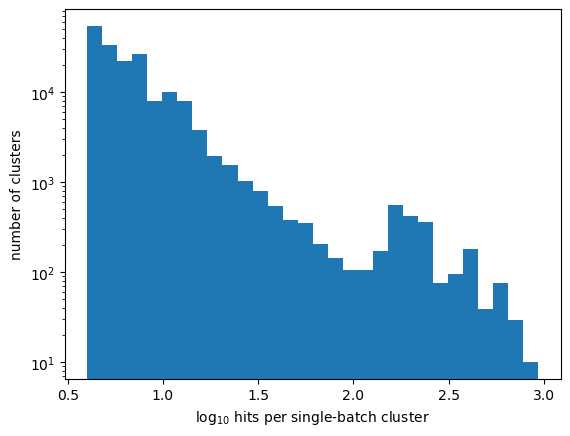

In [95]:
plt.hist(np.log10(counts), bins=30)
plt.yscale('log')
plt.xlabel(r'log$_{10}$ hits per single-batch cluster')
plt.ylabel('number of clusters')
plt.show()

In [6]:
lower_count_cci = []
lower_count_ccc = []
for i, count in enumerate(counts):
    if i%10000 == 0:
        print(i)
    if count > 10:
        continue
    #centroid = unique_ccc[i]
    iii = np.where(unique_inv == i)[0]
    idxs = cci[iii]
    cents = ccc[iii]
    lower_count_cci.append(idxs)
    lower_count_ccc.append(cents)
    #needed_params = hit_params[idxs]
    #needed_dats = hit_dats[idxs]
    #random_sample_idxs = np.random.choice(len(needed_params), 20, replace=False)
    #random_sample_params = needed_params[random_sample_idxs]
    #random_sample_dats = needed_dats[random_sample_idxs]
lower_count_cci = np.concatenate(lower_count_cci)
lower_count_ccc = np.concatenate(lower_count_ccc)
print(lower_count_cci.shape)
print(lower_count_ccc.shape)


0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000
170000
(842244,)
(842244, 13)


In [7]:
X_reduced = PCA(n_components=6, svd_solver='full').fit_transform(lower_count_ccc)

In [15]:
print(len(cci))
print(len(lower_count_cci))

1785050
842244


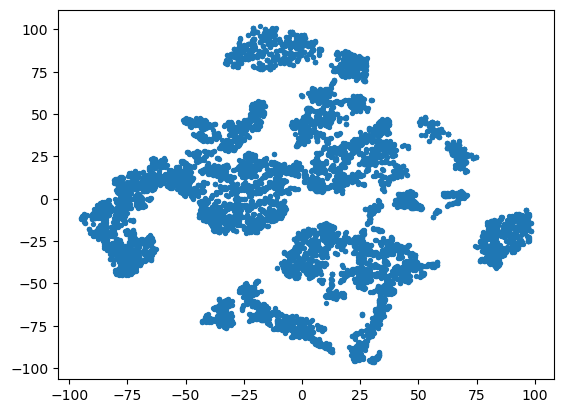

In [29]:
iii = np.random.randint(0, len(cci), 10000)

xembed = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=40, early_exaggeration=4).fit_transform(X_reduced[iii])

plt.scatter(xembed[:,0], xembed[:,1], s=8)
plt.show()

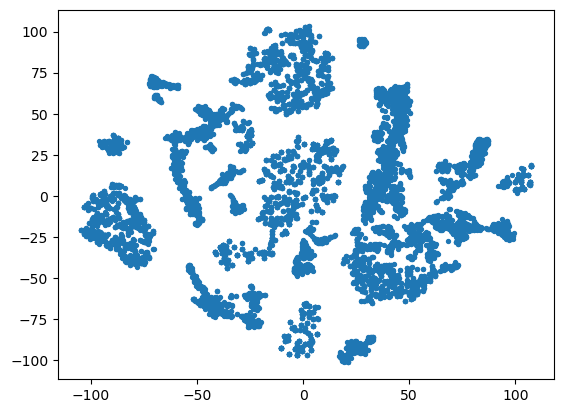

In [10]:
iii = np.random.randint(0, len(lower_count_cci), 10000)

xembed = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=40, early_exaggeration=4).fit_transform(X_reduced[iii])

plt.scatter(xembed[:,0], xembed[:,1], s=8)
plt.show()

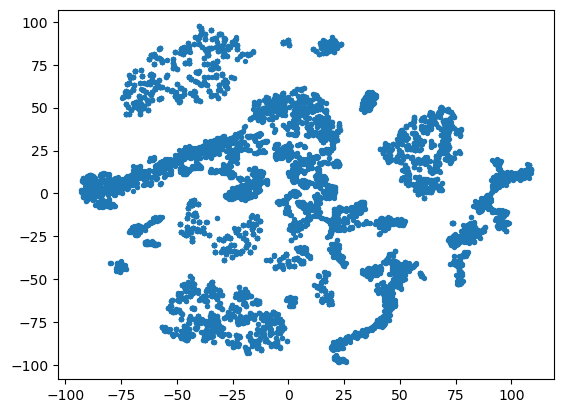

In [72]:
iii = np.random.randint(0, len(lower_count_cci), 10000)

xembed = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=40, early_exaggeration=4).fit_transform(X_reduced[iii])

plt.scatter(xembed[:,0], xembed[:,1], s=8)
plt.show()

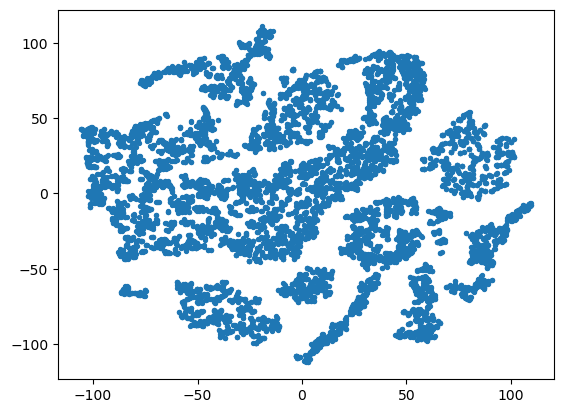

In [30]:
iii = np.random.randint(0, len(low_count_cci), 10000)

xembed_2 = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=20, early_exaggeration=4).fit_transform(X_reduced[iii])

plt.scatter(xembed_2[:,0], xembed_2[:,1], s=8)
plt.show()

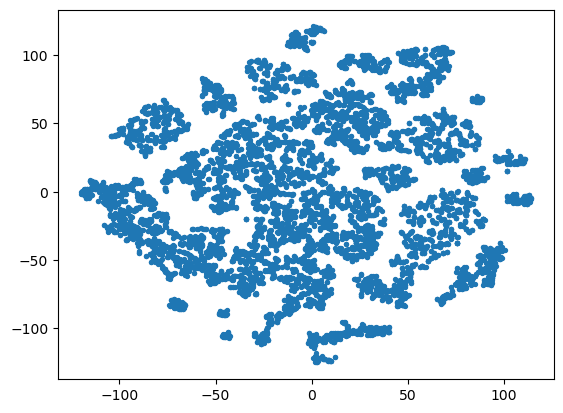

In [29]:
iii = np.random.randint(0, len(low_count_cci), 10000)

xembed_3 = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=15, early_exaggeration=4).fit_transform(X_reduced[iii])

plt.scatter(xembed_3[:,0], xembed_3[:,1], s=8)
plt.show()

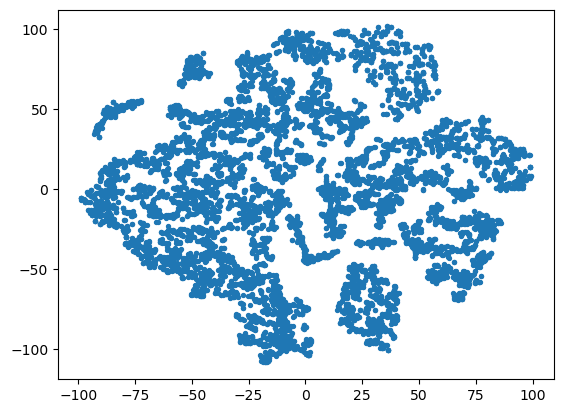

In [32]:
iii = np.random.randint(0, len(low_count_cci), 10000)

xembed_3 = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=20, early_exaggeration=10).fit_transform(X_reduced[iii])

plt.scatter(xembed_3[:,0], xembed_3[:,1], s=8)
plt.show()

40
[35  2 36 27 10 10 31  2 14 16  2  7  0  7  2 11 11  3  5 23 31  0  0  1
  2  0 28 37  3 27 20 15 27 10 36  2  2 31 10 26  7 28 11 26 13  7 35 38
 11 14  7 14 -1  2  7  0  7 11  2  7  7 31 31 27 27  3  0  2 14 31  0  1
  0 19  2  3  0 -1  7 14 38 12 14 31 31 37 31 13 10 31  2  5  2 -1 22 -1
 24 14  7 -1]


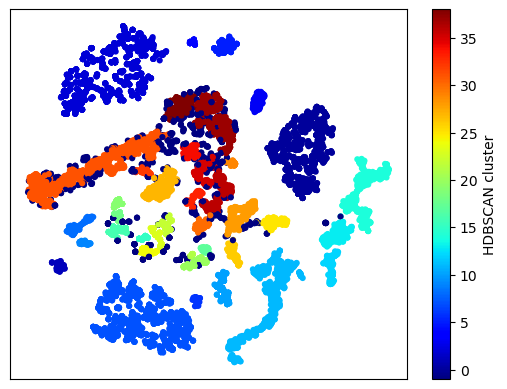

In [82]:
# Clustering t-SNE embedding with HDBSCAN instead -- will need to be spot-checked.

nmincluster = 12
nminsamples = 20
eps = 3

hdb = HDBSCAN(min_cluster_size=nmincluster, 
              min_samples=nminsamples, 
              cluster_selection_epsilon=eps, 
              cluster_selection_method='eom', 
              store_centers='centroid')

hdb.fit(xembed)

print(len(np.unique(hdb.labels_)))

print(hdb.labels_[:100])

fig, ax = plt.subplots()
s = ax.scatter(xembed[:,0], xembed[:,1], 
            c=hdb.labels_,
            cmap='jet',
            #vmin=-0.5, vmax=14.5,
            s=20, linewidths=0, alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(mappable=s, label=r'HDBSCAN cluster', ax=ax)
#plt.savefig('/datax/scratch/benjb/C23_L_HDBSCAN_TSNE_visualization_10k_hits_110424.pdf', bbox_inches='tight')
plt.show()

43
[ 3 -1 40 18 18 18 34 37  3 18 26 22 37 18 22 18 -1 29 29  0 18 18 28 29
 29 35 38 39  1  0 16 12  7 18 11 29 40 -1 18  1  7  8 29 15 18 29 37 40
 40 -1  6 25 18 11 21 18 18 29  0  1  2 18 40 22 40 18 -1  3  8 21 35 18
 12 -1 29 22 29 16  3 29  3 40 22 40 18 -1 34 20 40 18 40 18  6 40  3  2
 40 18  2 18]


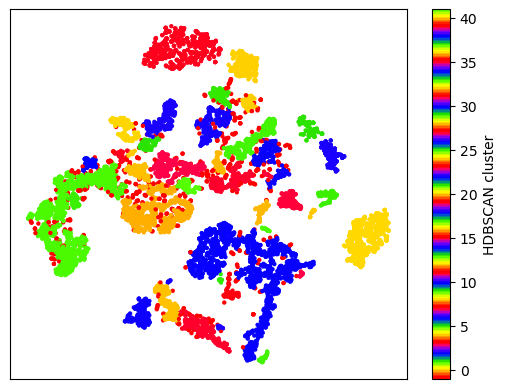

In [55]:
nmincluster = 10
nminsamples = 10
eps = 2.25

hdb = HDBSCAN(min_cluster_size=nmincluster, 
              min_samples=nminsamples, 
              cluster_selection_epsilon=eps, 
              cluster_selection_method='eom', 
              store_centers='centroid')

hdb.fit(xembed)

print(len(np.unique(hdb.labels_)))

print(hdb.labels_[:100])

fig, ax = plt.subplots()
s = ax.scatter(xembed[:,0], xembed[:,1], 
            c=hdb.labels_,
            cmap='prism',
            #vmin=-0.5, vmax=14.5,
            s=10, linewidths=0, alpha=1)
ax.set_xticks([])
ax.set_yticks([])
fig.colorbar(mappable=s, label=r'HDBSCAN cluster', ax=ax)
#plt.savefig('/datax/scratch/benjb/C23_L_HDBSCAN_TSNE_visualization_10k_hits_110424.pdf', bbox_inches='tight')
plt.show()

In [ ]:
np.save('/datax/scratch/benjb/C23_L_TSNE_anomaly_embedding.npy', xembed_2)

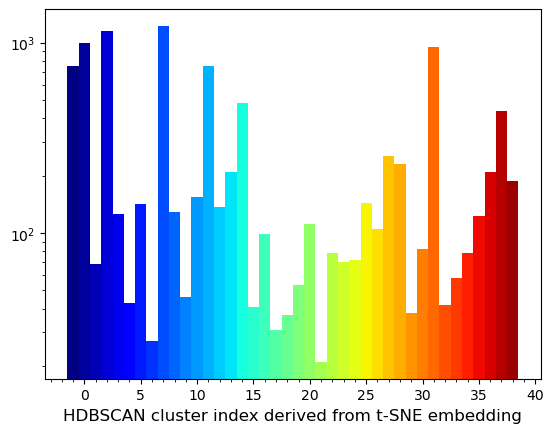

In [85]:
fig, ax = plt.subplots()
cm = plt.get_cmap('jet')
edges, bin, patches = ax.hist(hdb.labels_, bins=len(np.unique(hdb.labels_)),
         range=(np.min(hdb.labels_)-0.5, np.max(hdb.labels_)+0.5))
for j, p in enumerate(patches):
    #print(f'setting color on bar {j} ')
    p.set_facecolor(cm(j / len(patches)))
plt.yscale('log')
plt.minorticks_on()
plt.xlabel('HDBSCAN cluster index derived from t-SNE embedding', size=12)
#plt.ylabel('hits in cluster', size=12)
#plt.savefig('/datax/scratch/benjb/C23_L_HDBSCAN_tSNE_histogram.pdf', bbox_inches='tight')
plt.show()

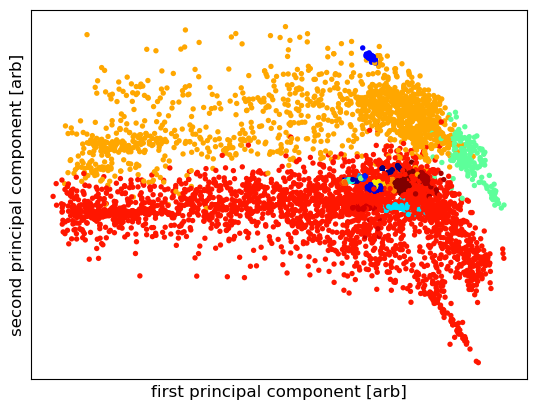

In [138]:
plt.scatter(X_reduced[iii,0], X_reduced[iii,1], s=15, c=hdb.labels_, cmap='jet', linewidths=0, alpha=1)
plt.xticks([])
plt.yticks([])
plt.xlabel('first principal component [arb]', size=12)
plt.ylabel('second principal component [arb]', size=12)
plt.savefig('/datax/scratch/benjb/C23_L_HDBSCAN_tSNE_PCA_visualization_10k.pdf', bbox_inches='tight')
plt.show()

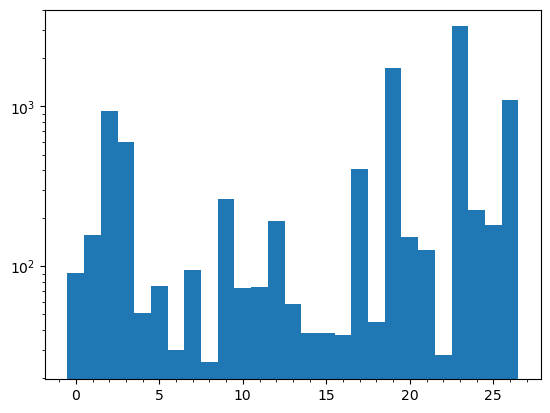

In [116]:
plt.hist(x=hdb.labels_, bins=len(np.unique(hdb.labels_)),
         range=(np.min(hdb.labels_)-0.5, np.max(hdb.labels_)+0.5)
         )
plt.minorticks_on()
plt.yscale('log')
plt.show()

ValueError: 'c' argument has 10000 elements, which is inconsistent with 'x' and 'y' with size 5000.

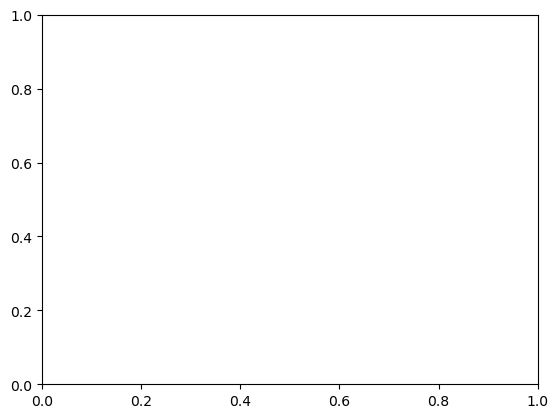

In [49]:
plt.scatter(xembed[:,0], xembed[:,1], c=kmeans.labels_[iii], cmap='jet', s=20, linewidths=0, alpha=1)
plt.colorbar()
plt.show()

In [32]:
for k in [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]:
    print([(k-8)//3, (k-8)%3])

[0, 0]
[0, 1]
[0, 2]
[1, 0]
[1, 1]
[1, 2]
[2, 0]
[2, 1]
[2, 2]
[3, 0]
[3, 1]
[3, 2]


8
9
10
11
12
13
14
15
16
17
18
19


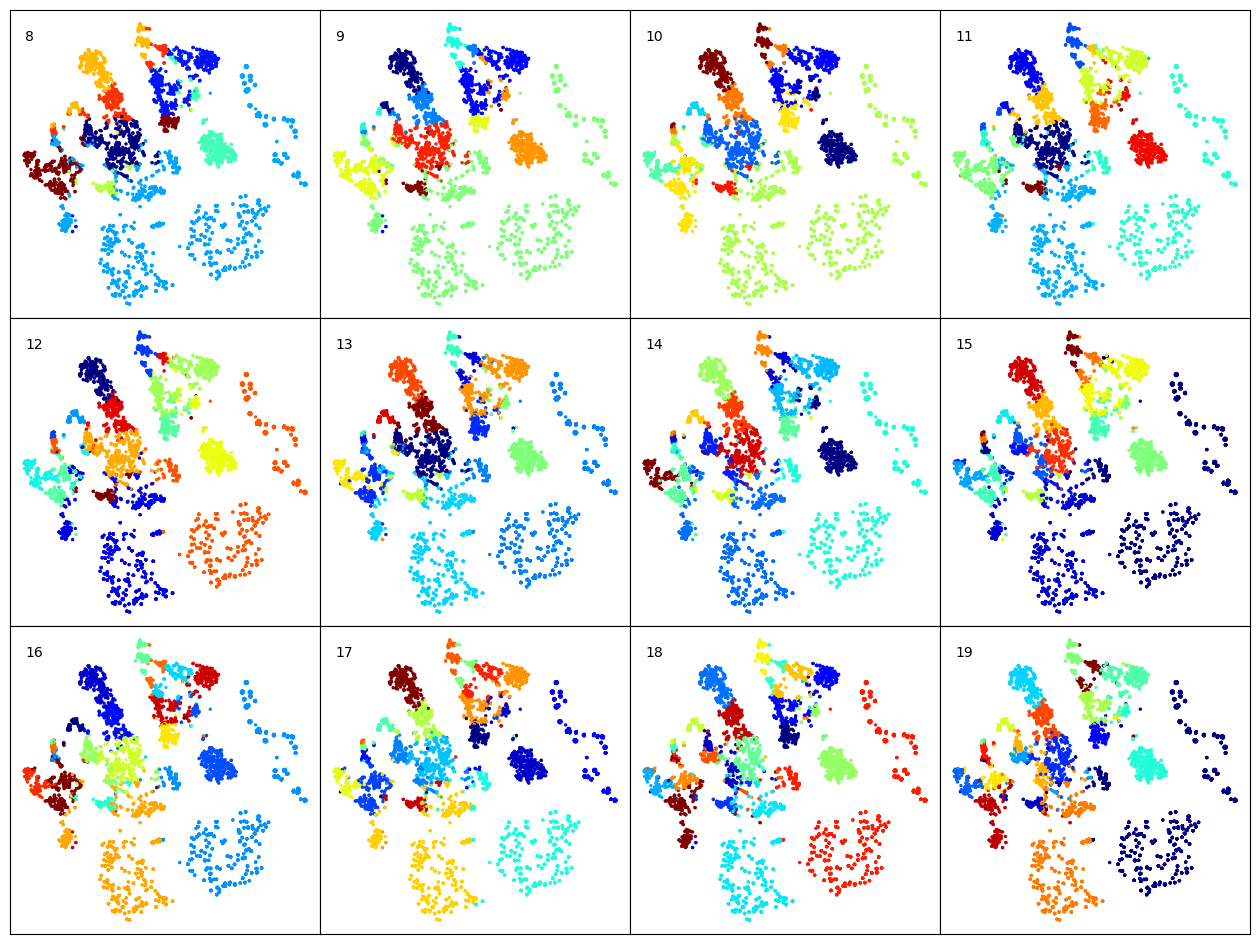

In [50]:
# Iterate over k values to see if any give compelling k-means results.

fig, axs = plt.subplots(3, 4, figsize=(16, 12))
for k in [8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]:
    print(k)
    kmeans = KMeans(init="random", n_clusters=k, n_init=40)
    kmeans.fit(X_reduced)
    x = (k-8)//4
    y = (k-8)%4
    axs[x][y].scatter(xembed[:,0], xembed[:,1], c=kmeans.labels_[iii], cmap='jet', s=6, linewidths=0, alpha=1)
    axs[x][y].text(0.05, 0.9, f'{k}', size=10, color='black', horizontalalignment='left', transform=axs[x][y].transAxes)
    axs[x][y].set_xticks([])
    axs[x][y].set_yticks([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('/datax/scratch/benjb/C23_L_kmeans_k_testing_.png', bbox_inches='tight')
plt.show()

13
14
15
16
17
18


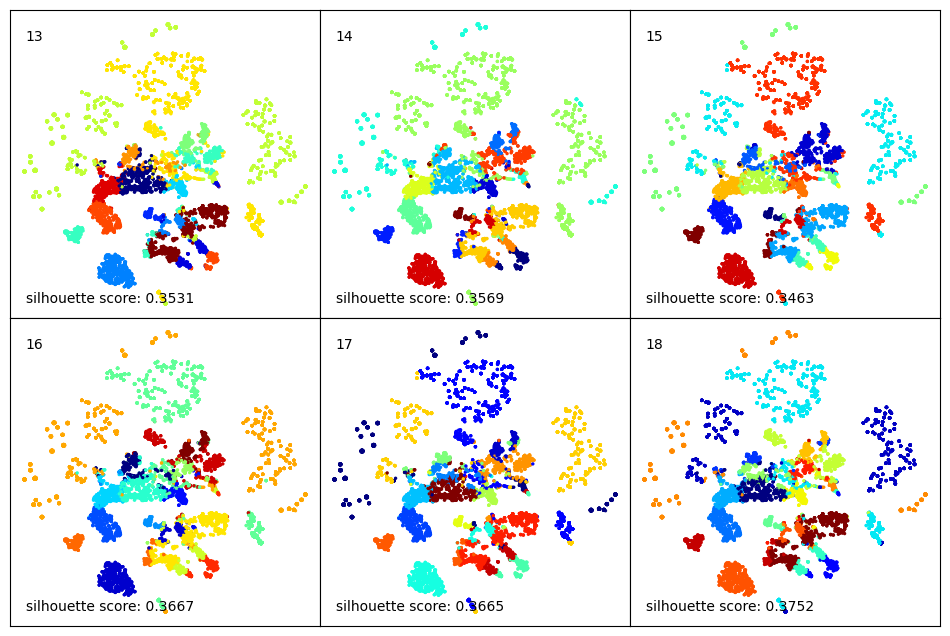

In [55]:
# Silhouette score for quantitative approach.

from sklearn.metrics import silhouette_score

fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for k in [13, 14, 15, 16, 17, 18]:
    print(k)
    kmeans = KMeans(init="random", n_clusters=k, n_init=10)
    kmeans.fit(X_reduced)
    silhouette_avg = silhouette_score(X_reduced, kmeans.labels_, sample_size=10000)
    x = (k-13)//3
    y = (k-13)%3
    axs[x][y].scatter(xembed_2[:,0], xembed_2[:,1], c=kmeans.labels_[iii], cmap='jet', s=6, linewidths=0, alpha=1)
    axs[x][y].text(0.05, 0.9, f'{k}', size=10, color='black', horizontalalignment='left', transform=axs[x][y].transAxes)
    axs[x][y].text(0.05, 0.05, f'silhouette score: {round(silhouette_avg, 4)}', size=10, color='black', horizontalalignment='left', transform=axs[x][y].transAxes)
    axs[x][y].set_xticks([])
    axs[x][y].set_yticks([])
plt.subplots_adjust(wspace=0, hspace=0)
plt.savefig('/datax/scratch/benjb/C23_L_kmeans_k_testing_silhouette.png', bbox_inches='tight')
plt.show()

In [58]:
from sklearn.manifold import TSNE # https://distill.pub/2016/misread-tsne/
X_embedded = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=30).fit_transform(X_reduced[:100000])

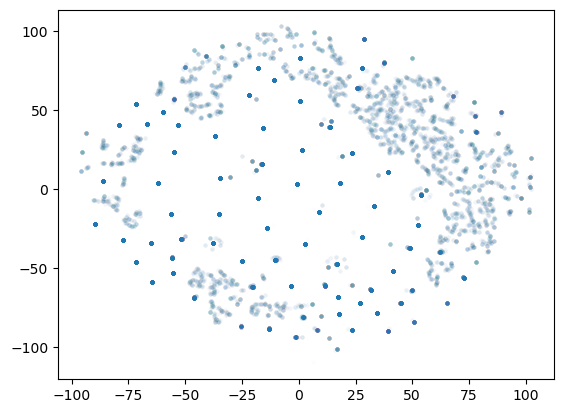

In [63]:
plt.scatter(X_embedded[:,0], X_embedded[:,1], s=10, linewidths=0, alpha=0.01)
plt.show()

In [77]:
idxs = list(set(np.arange(len(unique_params)))-set(cci))
print(len(idxs))

135679


In [76]:
unique_params = np.unique(params, axis=0)

In [78]:
unique_anomaly_params = unique_params[np.array(idxs)]

In [64]:
idxs = np.load('/datax/scratch/benjb/C23_L_anomalous_hit_idxs_round2.npy', allow_pickle=True)
params = np.load('/datax/scratch/benjb/C23_L_full_param_array.npy', allow_pickle=True)
dat = params[idxs]
print(dat.shape)

(1033399, 12)


In [83]:
xxx = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=30).fit_transform(unique_anomaly_params)

In [84]:
xxx.shape

(135679, 2)

In [94]:
np.save('/datax/scratch/benjb/C23_L_TSNE_anomaly_embedding.npy', xxx)

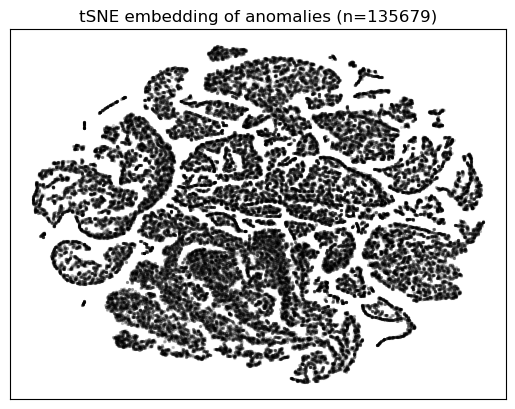

In [93]:
plt.scatter(xxx[:,0], xxx[:,1], s=5, linewidths=0, color='k', alpha=0.1)
plt.xticks([])
plt.yticks([])
plt.title('tSNE embedding of anomalies (n=135679)')
plt.savefig('/datax/scratch/benjb/C23_L_TSNE_anomaly_embedding.pdf', bbox_inches='tight')
plt.show()

In [8]:
# UMAP scratch work

reducer = umap.UMAP()
embedding = reducer.fit_transform(X_reduced[:1000])

In [18]:
reducer = umap.UMAP()

In [16]:
reducer = umap.UMAP()
embedding = reducer.fit_transform(X_reduced[:10000])

In [13]:
embedding.shape

(2000, 2)

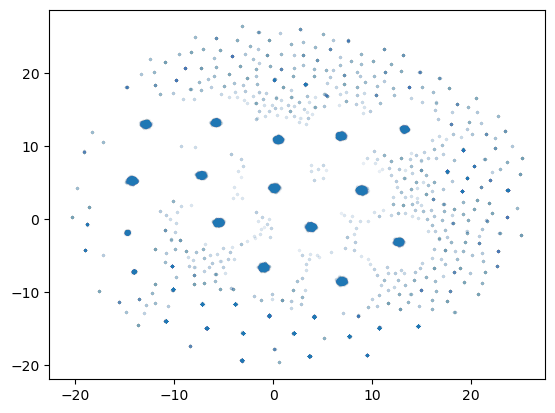

In [39]:
plt.scatter(embedding[:,0], embedding[:,1], s=3, alpha=0.01)
plt.show()

In [21]:
counts = [100, 250, 500, 1000, 2500, 5000, 10000, 25000, 50000]
times = []

import time

for count in counts:
    print(f'Working on {count}')
    start = time.time()
    reducer = umap.UMAP()
    embedding = reducer.fit_transform(X_reduced[:count])
    end = time.time()
    t = end - start
    times.append(t)
    

Working on 100
Working on 250
Working on 500
Working on 1000
Working on 2500
Working on 5000
Working on 10000
Working on 25000


/home/benjb/.conda/envs/sklearn-env/lib/python3.12/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(
/home/benjb/.conda/envs/sklearn-env/lib/python3.12/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


Working on 50000


/home/benjb/.conda/envs/sklearn-env/lib/python3.12/site-packages/umap/spectral.py:550: UserWarning: Spectral initialisation failed! The eigenvector solver
failed. This is likely due to too small an eigengap. Consider
adding some noise or jitter to your data.

Falling back to random initialisation!
  warn(


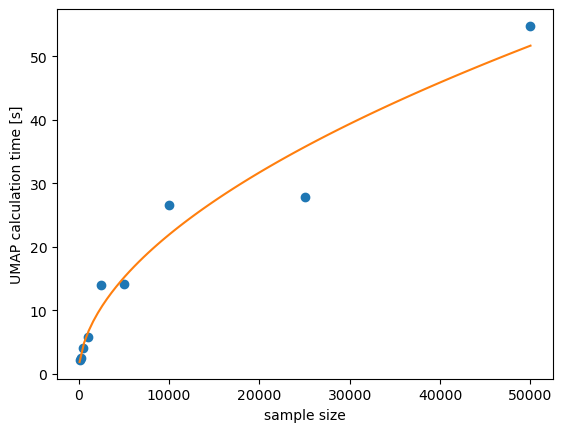

In [33]:
z = np.polyfit(np.log10(counts), np.log10(times), 1)
p = np.poly1d(z)

xxx = np.linspace(np.min(counts), np.max(counts), 100)

plt.plot(counts, times, 'o')
plt.plot(xxx, 10**(p(np.log10(xxx))))
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('sample size')
plt.ylabel('UMAP calculation time [s]')
plt.show()

In [34]:
print(p(len(X_reduced)))

949897.1650218107
